# SNN-MLP-Univariate-BOOTSTRAP-Network-ANN-SNN-LAVA

In [1]:
import os, sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# import slayer from lava-dl
from tqdm import tqdm
from lava.lib.dl.decolle.loss import DECOLLELoss
from lava.lib.dl.decolle.utils import DECOLLEAssistant
import lava 
import lava.lib.dl.slayer as slayer
import lava.lib.dl.bootstrap as bootstrap

import IPython.display as display
from matplotlib import animation
from pandas import read_csv
#import utils
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

# MLP Bootstrap Univarite

In [27]:
data = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')
#data = read_csv('Palestine-PV.csv', parse_dates=['date'], index_col='date')
# Convert index to datetime
data.index = pd.to_datetime(data.index)
# Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
data = data.sort_index()
# manually specify column names
# Now select the first column after the index
data = data.iloc[:, 5] 
print(data.shape)
# summarize first 5 rows
#print(data.head(7))
#print(data.tail(7))
#print(data.describe().T)  
print(data.isnull().sum())
data.info()
#plt.plot(data)
data = data[~np.isnan(data)]
data = data.dropna()
data = data.astype('float64')
# Convert the Series to a numpy array and reshape
data= np.array(data).reshape(-1, 1)
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).
def to_sequences(dataset, seq_size=3):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)


seq_size =3# Number of time steps to look back 


#Larger sequences (look further back) may improve forecasting.
train_X, train_y = to_sequences(train, seq_size)
test_X, test_y = to_sequences(test, seq_size)
print(train_X.shape, train_y.shape, test_X.shape, test_y .shape)
# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y)
#Reshape for Conv4d
train_X = train_X.reshape((train_X.shape[0],train_X.shape[1], 1,1))
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1], 1,1 ))

class Network(torch.nn.Module):
    def __init__(self, time_steps=16):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
                'threshold'     : 0.5,
                'current_decay' : 1, # this must be 1 to use batchnorm
                'voltage_decay' : 0.03,
                'tau_grad'      : 1,
                'scale_grad'    : 1,
            }
        neuron_params_norm = {
                **neuron_params,
                 #'norm'    : slayer.neuron.norm.MeanOnlyBatchNorm,
                 #'dropout' : slayer.neuron.Dropout(p=0.2), # neuron dropout
            }
        self.blocks = torch.nn.ModuleList([
                bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0), # enable affine transform at input
                bootstrap.block.cuba.Dense(neuron_params_norm, 3, 32),
                bootstrap.block.cuba.Dense(neuron_params_norm,32, 32),
                bootstrap.block.cuba.Affine(neuron_params, 32, 1),
            ])
   
    def forward(self, x, mode):
        N, C, H, W = x.shape
        if mode.base_mode == bootstrap.Mode.ANN:
            x = x.reshape([N, C, H, W, 1])
            #print("Input shape:", x.shape)
        else:
            x = slayer.utils.time.replicate(x, self.time_steps)

        #x = x.reshape(N, -1, x.shape[-1])
      
        for block, m in zip(self.blocks, mode):
            x = block(x, mode=m)
        
   
        return x


  # Instantiate Network, Optimizer, DataSet and DataLoader
batch  =64# batch size
lr     = 0.001 # leaerning rate
lam    = 0.01  # lagrangian for event rate loss
epochs =60 # training epochs
steps  = [60, 120, 160] # learning rate reduction milestones
trained_folder = 'Trained'
logs_folder = 'Logs'
os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder   , exist_ok=True)
#device = torch.device('cuda')
device = torch.device('cpu')
net = Network().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # learning rate reduction milestones
# Dataset and dataLoader instances.
training_set = torch.utils.data.TensorDataset(train_X, train_y)
testing_set = torch.utils.data.TensorDataset(test_X, test_y)
train_loader = DataLoader(dataset=training_set, batch_size=batch, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=batch, shuffle=False)
stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

for epoch in range(epochs):
    for i, (input, label) in enumerate(train_loader, 0):
        net.train()
        mode = scheduler.mode(epoch, i, net.training)

        input = input.to(device)
        output = net.forward(input, mode)
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        label = label.view(-1, 1).to(device)  # reshaping the label tensor to have a size of 1 in the second dimension
        loss = F.mse_loss(rate, label)

        #prediction = rate.data.max(1, keepdim=True)[1].cpu().flatten()

        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]
        #stats.training.correct_samples += torch.sum( prediction == label ).data.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
    event_counts = []
    counts = []
    for i, (input, label) in enumerate(test_loader, 0):
        net.eval()
        mode = scheduler.mode(epoch, i, net.training)

        with torch.no_grad():
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epoch, i, net.training))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
            # Here we compute the event rate
            
            count = (output > 0).sum(dim=-1).float()  # Counts the number of positive (firing) events
            mean_count = count.mean(dim=0).tolist()# This line is changed to average over batch dimension
            counts.append(mean_count)

            label = label.view(-1, 1).to(device)  # reshaping the label tensor to have a size of 1 in the second dimension
            loss = F.mse_loss(rate, label)
            #loss = F.mse_loss(rate, label.to(device))
            #prediction = rate.data.max(1, keepdim=True)[1].cpu().flatten()

        stats.testing.num_samples += len(label)
        stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]
        #stats.testing.correct_samples += torch.sum( prediction == label ).data.item()

    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
    
    # Now that we're sure that all entries have the same length, calculate the mean
    counts = np.mean(counts, axis=1)
    #print('Mean Event Rate:', counts)
  
    if mode.base_mode == bootstrap.routine.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        print(mode)
        print(f'[Epoch {epoch:2d}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_loss:
            torch.save(net.state_dict(), trained_folder + '/network.pt')
        scheduler.update_snn_stat()

    stats.update()
    stats.save(trained_folder + '/')


C:\Users\bahgat.ayasi\AppData\Local\Temp\ipykernel_11648\1618010434.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')


(26280,)
0
<class 'pandas.core.series.Series'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Series name: Solar Radiation(GHI)
Non-Null Count  Dtype  
--------------  -----  
26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB
(21020, 3) (21020,) (5252, 3) (5252,)
                                                                                                                                                             
Mode: SNN
[Epoch  0/60]
SNN Testing: loss =     0.01926                          accuracy = 0.00000 
                                                                                                                                                                                           
Mode: SNN
[Epoch 10/60]
SNN Testing: loss =     0.01381 (min =     0.01926)     accuracy = 0.00000 (max = 0.00000) 
                                                                                                                                   

#  Evaluation: Calculate and Print Unnormalized RMSE and MAE for Testing Set

Test RMSE (Unnormalized): 28.5090
Test MAE (Unnormalized): 17.7573


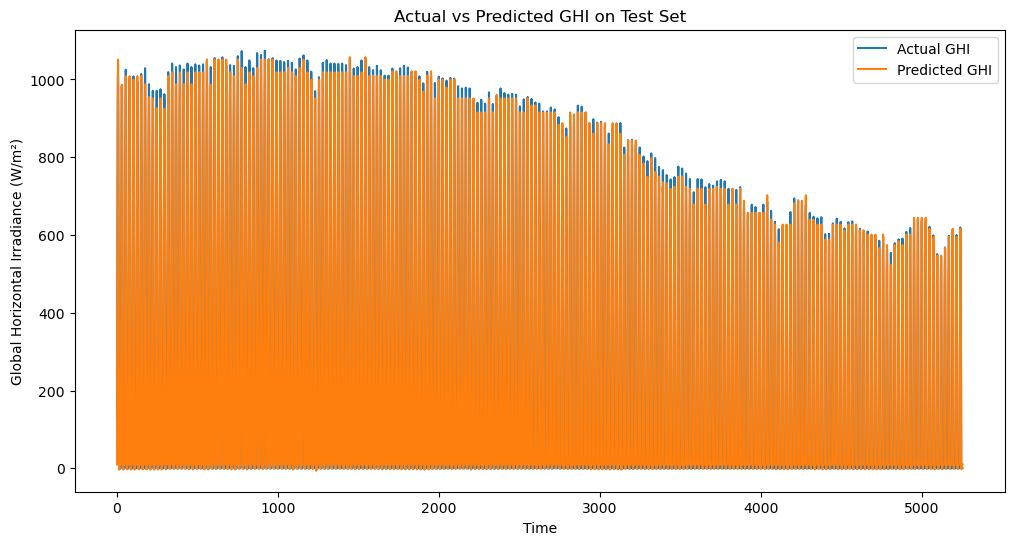

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is in evaluation mode
net.eval()

all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    # If you're evaluating after training, ensure 'epoch' is set appropriately.
    # For example, if you have completed all training epochs, you might set epoch to epochs-1
    # Alternatively, if evaluation is within the training loop, use the current epoch value.
    evaluation_epoch = epochs - 1  # Adjust based on your training loop structure

    for i, (input, label) in enumerate(test_loader):
        # Obtain the current mode using the scheduler
        # Pass False to indicate evaluation phase
        current_mode = scheduler.mode(evaluation_epoch, i, False)

        # Move input and label to the appropriate device
        input = input.to(device)
        label = label.to(device)

        # Forward pass with the current mode
        output = net(input, mode=current_mode)

        # Compute the rate as done during training
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        # Inverse transform the predictions and actual values
        test_predictions_inv = scaler.inverse_transform(rate.cpu().numpy())
        test_y_inv = scaler.inverse_transform(label.cpu().numpy().reshape(-1, 1))

        # Accumulate predictions and labels
        all_predictions.append(test_predictions_inv)
        all_labels.append(test_y_inv)

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Calculate RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(all_labels, all_predictions))
test_mae = mean_absolute_error(all_labels, all_predictions)

print(f"Test RMSE (Unnormalized): {test_rmse:.4f}")
print(f"Test MAE (Unnormalized): {test_mae:.4f}")

# Optionally, plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(all_labels, label='Actual GHI')
plt.plot(all_predictions, label='Predicted GHI')
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.title('Actual vs Predicted GHI on Test Set')
plt.legend()
plt.show()


# SNN-CNN-Univariate-BOOTSTRAP-Network-ANN-SNN-LAVA

In [30]:
data = read_csv('jordan_pv.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
#data = read_csv('Palestine-PV.csv', parse_dates=['date'], index_col='date')
# Convert index to datetime
data.index = pd.to_datetime(data.index)
# Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
data = data.sort_index()
# manually specify column names
# Now select the first column after the index
data = data.iloc[:, 5] 
print(data.shape)
# summarize first 5 rows
#print(data.head(7))
#print(data.tail(7))
#print(data.describe().T)  
print(data.isnull().sum())
data.info()
#plt.plot(data)
data = data[~np.isnan(data)]
data = data.dropna()
data = data.astype('float64')
# Convert the Series to a numpy array and reshape
data= np.array(data).reshape(-1, 1)
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
train_size = int(len(data) * 0.80)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)


seq_size =3# Number of time steps to look back 


#Larger sequences (look further back) may improve forecasting.
train_X, train_y = to_sequences(train, seq_size)
test_X, test_y = to_sequences(test, seq_size)
print(train_X.shape, train_y.shape, test_X.shape, test_y .shape)
# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y)
#Reshape for Conv4d
train_X = train_X.reshape((train_X.shape[0],train_X.shape[1], 1,1))
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1], 1,1 ))

class Network(torch.nn.Module):
    def __init__(self, time_steps=16):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
                'threshold'     : 0.5,
                'current_decay' : 1, # this must be 1 to use batchnorm
                'voltage_decay' : 0.03,
                'tau_grad'      : 1,
                'scale_grad'    : 1,
            }
        neuron_params_norm = {
                **neuron_params,
                 #'norm'    : slayer.neuron.norm.MeanOnlyBatchNorm,
                 #'dropout' : slayer.neuron.Dropout(p=0.2), # neuron dropout
            }
        self.blocks = torch.nn.ModuleList([
                bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0), # enable affine transform at input
                bootstrap.block.cuba.Conv(neuron_params_norm,3,32, kernel_size=1),
                bootstrap.block.cuba.Conv(neuron_params_norm,32,32, kernel_size=1),
                bootstrap.block.cuba.Flatten(),
                bootstrap.block.cuba.Dense(neuron_params_norm, 32, 32),
                bootstrap.block.cuba.Dense(neuron_params_norm,32, 32),
                bootstrap.block.cuba.Affine(neuron_params, 32, 1),
            ])
   
    def forward(self, x, mode):
        N, C, H, W = x.shape
        if mode.base_mode == bootstrap.Mode.ANN:
            x = x.reshape([N, C, H, W, 1])
            #print("Input shape:", x.shape)
        else:
            x = slayer.utils.time.replicate(x, self.time_steps)

        #x = x.reshape(N, -1, x.shape[-1])
      
        for block, m in zip(self.blocks, mode):
            x = block(x, mode=m)
        
   
        return x


  # Instantiate Network, Optimizer, DataSet and DataLoader
batch  =64# batch size
lr     = 0.001 # leaerning rate
lam    = 0.01  # lagrangian for event rate loss
epochs =60 # training epochs
steps  = [60, 120, 160] # learning rate reduction milestones
trained_folder = 'Trained'
logs_folder = 'Logs'
os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder   , exist_ok=True)
#device = torch.device('cuda')
device = torch.device('cpu')
net = Network().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # learning rate reduction milestones
# Dataset and dataLoader instances.
training_set = torch.utils.data.TensorDataset(train_X, train_y)
testing_set = torch.utils.data.TensorDataset(test_X, test_y)
train_loader = DataLoader(dataset=training_set, batch_size=batch, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=batch, shuffle=False)
stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

for epoch in range(epochs):
    for i, (input, label) in enumerate(train_loader, 0):
        net.train()
        mode = scheduler.mode(epoch, i, net.training)

        input = input.to(device)
        output = net.forward(input, mode)
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        label = label.view(-1, 1).to(device)  # reshaping the label tensor to have a size of 1 in the second dimension
        loss = F.mse_loss(rate, label)

        #prediction = rate.data.max(1, keepdim=True)[1].cpu().flatten()

        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]
        #stats.training.correct_samples += torch.sum( prediction == label ).data.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
    event_counts = []
    counts = []
    for i, (input, label) in enumerate(test_loader, 0):
        net.eval()
        mode = scheduler.mode(epoch, i, net.training)

        with torch.no_grad():
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epoch, i, net.training))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
            # Here we compute the event rate
            
            count = (output > 0).sum(dim=-1).float()  # Counts the number of positive (firing) events
            mean_count = count.mean(dim=0).tolist()# This line is changed to average over batch dimension
            counts.append(mean_count)

            label = label.view(-1, 1).to(device)  # reshaping the label tensor to have a size of 1 in the second dimension
            loss = F.mse_loss(rate, label)
            #loss = F.mse_loss(rate, label.to(device))
            #prediction = rate.data.max(1, keepdim=True)[1].cpu().flatten()

        stats.testing.num_samples += len(label)
        stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]
        #stats.testing.correct_samples += torch.sum( prediction == label ).data.item()

    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
    
    # Now that we're sure that all entries have the same length, calculate the mean
    counts = np.mean(counts, axis=1)
    #print('Mean Event Rate:', counts)
  
    if mode.base_mode == bootstrap.routine.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        print(mode)
        print(f'[Epoch {epoch:2d}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_loss:
            torch.save(net.state_dict(), trained_folder + '/network.pt')
        scheduler.update_snn_stat()

    stats.update()
    stats.save(trained_folder + '/')


C:\Users\bahgat.ayasi\AppData\Local\Temp\ipykernel_11648\2556596545.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = read_csv('jordan_pv.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
C:\Users\bahgat.ayasi\AppData\Local\Temp\ipykernel_11648\2556596545.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = read_csv('jordan_pv.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')


(26280,)
0
<class 'pandas.core.series.Series'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Series name: Solar Radiation(GHI)
Non-Null Count  Dtype  
--------------  -----  
26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB
(21020, 3) (21020,) (5252, 3) (5252,)
                                                                                                                                                             
Mode: SNN
[Epoch  0/60]
SNN Testing: loss =     0.04176                          accuracy = 0.00000 
                                                                                                                                                                                           
Mode: SNN
[Epoch 10/60]
SNN Testing: loss =     0.03444 (min =     0.04176)     accuracy = 0.00000 (max = 0.00000) 
                                                                                                                                   

#  Evaluation: Calculate and Print Unnormalized RMSE and MAE for Testing Set

Test RMSE (Unnormalized): 28.3933
Test MAE (Unnormalized): 17.7482


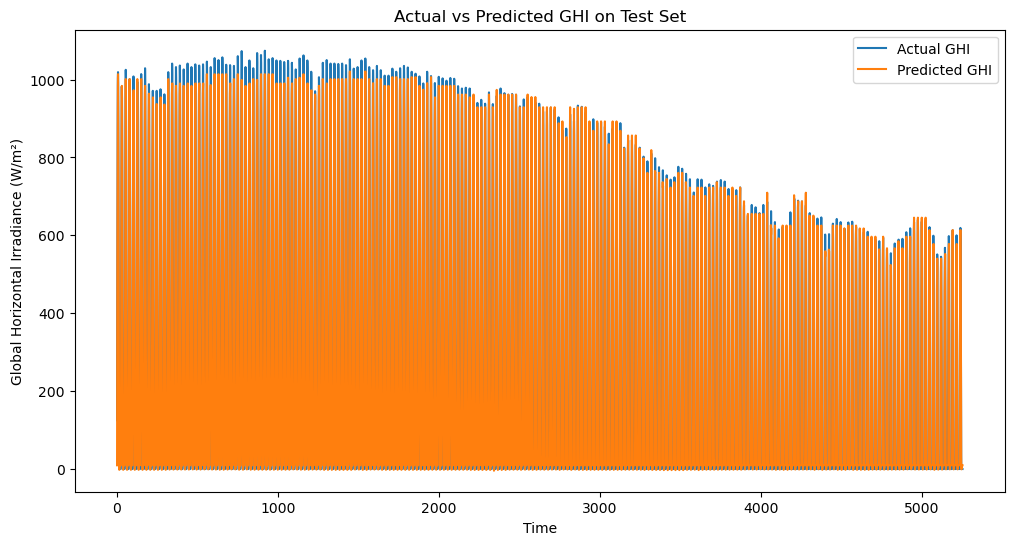

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is in evaluation mode
net.eval()

all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    # If you're evaluating after training, ensure 'epoch' is set appropriately.
    # For example, if you have completed all training epochs, you might set epoch to epochs-1
    # Alternatively, if evaluation is within the training loop, use the current epoch value.
    evaluation_epoch = epochs - 1  # Adjust based on your training loop structure

    for i, (input, label) in enumerate(test_loader):
        # Obtain the current mode using the scheduler
        # Pass False to indicate evaluation phase
        current_mode = scheduler.mode(evaluation_epoch, i, False)

        # Move input and label to the appropriate device
        input = input.to(device)
        label = label.to(device)

        # Forward pass with the current mode
        output = net(input, mode=current_mode)

        # Compute the rate as done during training
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        # Inverse transform the predictions and actual values
        test_predictions_inv = scaler.inverse_transform(rate.cpu().numpy())
        test_y_inv = scaler.inverse_transform(label.cpu().numpy().reshape(-1, 1))

        # Accumulate predictions and labels
        all_predictions.append(test_predictions_inv)
        all_labels.append(test_y_inv)

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Calculate RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(all_labels, all_predictions))
test_mae = mean_absolute_error(all_labels, all_predictions)

print(f"Test RMSE (Unnormalized): {test_rmse:.4f}")
print(f"Test MAE (Unnormalized): {test_mae:.4f}")

# Optionally, plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(all_labels, label='Actual GHI')
plt.plot(all_predictions, label='Predicted GHI')
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.title('Actual vs Predicted GHI on Test Set')
plt.legend()
plt.show()


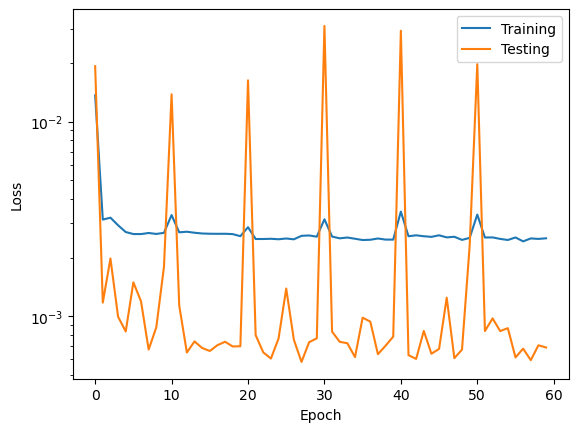

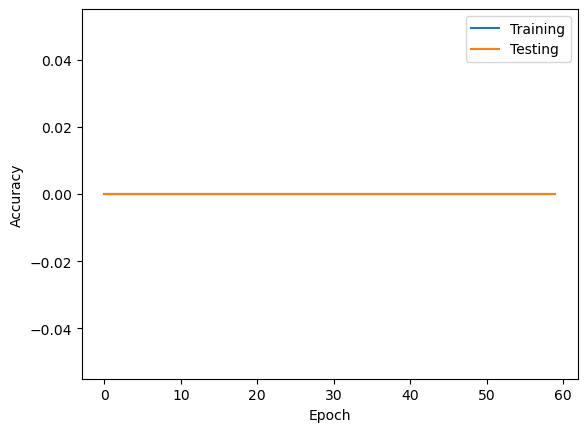

In [29]:
stats.plot()

In [27]:
import time

# Start the timer
start_time = time.time()

for epoch in range(epochs):
    # ... existing training code ...

    if scheduler.mode(epoch, 0, net.training).base_mode == bootstrap.routine.Mode.SNN: 
        event_counts = []

        # Adjusted loop: Process only the first 4 batches
        for i, (input, label) in enumerate(test_loader, 0):
            if i >= 7:  # Exit the loop after processing 4 batches
                break

            net.eval()
            mode = scheduler.mode(epoch, i, net.training)

            with torch.no_grad():
                input = input.to(device)
                output = net.forward(input, mode)
                rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

                # Compute the event rate for SNN mode
                count = (output > 0).sum(dim=-1).float()  # Counts the number of positive (firing) events
                mean_count = count.mean(dim=0).tolist()  # Average over batch dimension
                event_counts.append(mean_count)

                # ... existing loss calculation and other code ...

        # Calculate the mean event rate across the first 4 batches
        counts = np.mean(event_counts, axis=1)
        print('Mean Event Rate in SNN Mode:', counts)

    # ... rest of the epoch code ...

    # Stop the timer for each epoch
    end_time = time.time()
    elapsed_time = end_time - start_time
    #print(f"Epoch {epoch} completed in {elapsed_time} seconds.")

# ... existing code for saving the model, updating stats, etc. ...


Mean Event Rate in SNN Mode: [17.59375  24.671875 24.9375   17.6875   24.484375 25.125    17.734375]
Mean Event Rate in SNN Mode: [17.59375  24.671875 24.9375   17.6875   24.484375 25.125    17.734375]
Mean Event Rate in SNN Mode: [17.59375  24.671875 24.9375   17.6875   24.484375 25.125    17.734375]
Mean Event Rate in SNN Mode: [17.59375  24.671875 24.9375   17.6875   24.484375 25.125    17.734375]
Mean Event Rate in SNN Mode: [17.59375  24.671875 24.9375   17.6875   24.484375 25.125    17.734375]
Mean Event Rate in SNN Mode: [17.59375  24.671875 24.9375   17.6875   24.484375 25.125    17.734375]


In [28]:
utils.compare_ops(net, counts, mse=stats.testing.min_loss)

NameError: name 'utils' is not defined

In [ ]:
import importlib.util

spec = importlib.util.spec_from_file_location("desired_utils", "D:/Profiles/anaconda/Lib/site-packages/lava-dl/tutorials/lava/lib/dl/slayer/pilotnet/utils.py")
desired_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(desired_utils)

# Now you can use desired_utils as the module
#desired_utils.compare_ops()

In [29]:
#utils.compare_ops(net, counts, mse=stats.testing.min_loss)
print(f"Length of counts: {len(counts)}")
print(f"Number of layers in net.blocks: {len(net.blocks)}")

desired_utils.compare_ops(net, counts, mse=stats.testing.min_loss)

Length of counts: 7
Number of layers in net.blocks: 7
|-----------------------------------------------------------------------------|
|                         |          SDNN           |           ANN           |
|-----------------------------------------------------------------------------|
|         |     Shape     |  Events  |    Synops    | Activations|    MACs    |
|-----------------------------------------------------------------------------|
| layer-0 | (  1,  1,  3) |    17.59 |              |          3 |            |
| layer-1 | (  1,  1, 32) |    24.67 |       563.00 |         32 |         96 |
| layer-2 | (  1,  1, 32) |    24.94 |       789.50 |         32 |       1024 |
| layer-3 | (  1,  1, 32) |    17.69 |       798.00 |         32 |       1024 |
| layer-4 | (  1,  1, 32) |    24.48 |       566.00 |         32 |       1024 |
| layer-5 | (  1,  1,  1) |    25.12 |        24.48 |          1 |         32 |
| layer-6 | 

IndexError: list index out of range

In [14]:
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

Total number of parameters: 3202
